# Vehicle Detection
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

This project implements a software pipeline to detect vehicles in a video.  

The Project
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import importlib
import numpy as np
from sklearn import svm
from skimage.feature import hog
%matplotlib inline

np.random.seed(12061979) # make random number generation repeatable

## Image Plotting

In [27]:
import itertools
import math

def plot_images_grid(images, cmap=None, labels=[]):
    plt.axis('off')
    grid_cols = 2 if len(images) >=2 else 1
    
    grid_rows = math.ceil(len(images)/float(grid_cols))
    fig_height_inches = (16/grid_cols)*grid_rows
    fig, axes = plt.subplots(len(images), grid_cols, figsize=(16, fig_height_inches))
    fig.subplots_adjust(wspace=0.001, hspace=0.2)

    for ax, image, label in itertools.zip_longest(axes.ravel(), images, labels):
        if image is not None:
            ax.imshow(image, cmap=cmap)
            if label is not None:
                ax.set_title(label)
        ax.axis('off')
    
def plot_image(img):
    plt.imshow(img, cmap='gray')

## Load Test Images

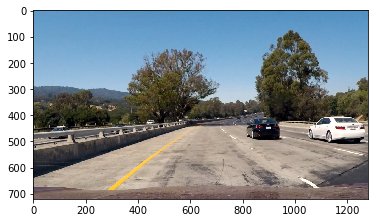

In [28]:
import glob
image_files = glob.glob('./test_images/*.jpg')
imgs_test = []
for img_file in image_files:
    imgs_test.append(cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB))

plt.imshow(imgs_test[0])

## Load Training Data Set

In [29]:
vehicle_img_files = glob.glob('training_dataset/vehicles/**/*.png')
nonvehicle_img_files = glob.glob('training_dataset/non-vehicles/**/*.png')
print(len(vehicle_imgs), len(nonvehicle_imgs))

def load_img(file):
    return mpimg.imread(file)

vehicle_imgs = [load_img(file) for file in vehicle_img_files]
nonvehicle_imgs = [load_img(file) for file in vehicle_img_files]

8792 8968


## Show Training Data Set Samples

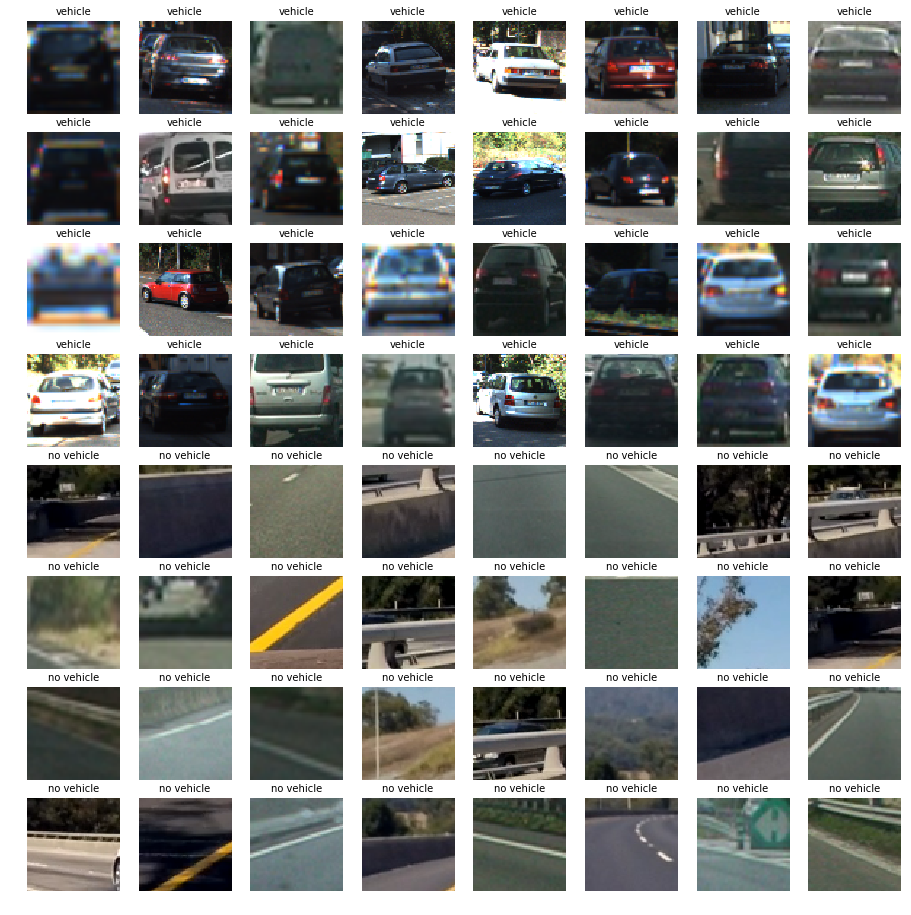

In [13]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(vehicle_imgs[np.random.randint(0,len(vehicle_imgs))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('vehicle', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(nonvehicle_imgs[np.random.randint(0,len(nonvehicle_imgs))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('no vehicle', fontsize=10)
    axs[i].imshow(img)

## HOG Feature Extraction

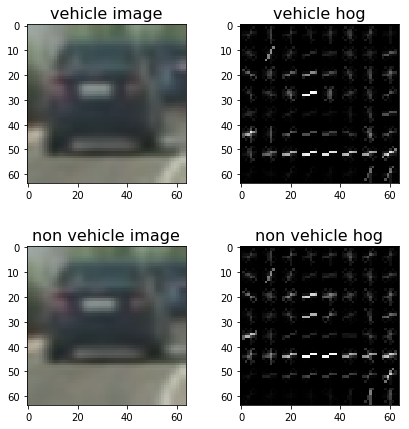

In [30]:
from skimage.feature import hog

def hog_features(img, orientation, pixels_per_cell, cells_per_block, visualise):
    features, hog_image = hog(
        img, 
        orientations=orientation, 
        pixels_per_cell=(pixels_per_cell, pixels_per_cell),
        cells_per_block=(cells_per_block, cells_per_block), 
        transform_sqrt=False, 
        visualise=visualise, 
        feature_vector=True)
    return features, hog_image

# TODO: Change code
# TODO why '2' in third dimension of array?
# TODO what is '9' in terms of orientation?
vehicle_img = vehicle_imgs[0]
_, vehicle_hog = hog_features(vehicle_img[:,:,2], orientation=9, pixels_per_cell=8, 
                              cells_per_block=8, visualise=True)

nonvehicle_img = nonvehicle_imgs[1]
_, nonvehicle_hog = hog_features(nonvehicle_img[:,:,2], orientation=9, pixels_per_cell=8, 
                                 cells_per_block=8, visualise=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(vehicle_img)
ax1.set_title('vehicle image', fontsize=16)
ax2.imshow(vehicle_hog, cmap='gray')
ax2.set_title('vehicle hog', fontsize=16)
ax3.imshow(nonvehicle_img)
ax3.set_title('non vehicle image', fontsize=16)
ax4.imshow(nonvehicle_hog, cmap='gray')
ax4.set_title('non vehicle hog', fontsize=16)


## HOG for Training Data Set

In [31]:
def features_for_images(imgs, cvt_color, orientation,  pixels_per_cell, cells_per_block, channels):
    imgs_features = []
    for img in imgs:
        img_features = []
        
        for channel in channels:
            channel_features = hog(
                img[:,:,channel], 
                orientations=orientation, 
                pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                cells_per_block=(cells_per_block, cells_per_block), 
                transform_sqrt=False, 
                visualise=False, 
                feature_vector=True)
            img_features.append(channel_features
                               )
        img_features = np.ravel(img_features)        
        imgs_features.append(img_features)
    
    return imgs_features

In [33]:
# TODO load training images into memory?

def build_dataset(cvt_color, orientation, pixels_per_cell, cells_per_block, channels):
    vehicles_features = features_for_images(
        vehicle_imgs, cvt_color=cvt_color, orientation=orientation, 
        pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, channels=channels)
    nonvehicles_features = features_for_images(
        nonvehicle_imgs, cvt_color=cvt_color, orientation=orientation, 
        pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, channels=channels)

    # TODO why is astype(np.float64) required?
    X = np.vstack((vehicles_features, nonvehicles_features)).astype(np.float64)  
    y = np.hstack((np.ones(len(vehicles_features)), np.zeros(len(nonvehicles_features))))
    
    return X, y

X, y = build_dataset(
    cvt_color=cv2.COLOR_RGB2YUV, 
    orientation=11, 
    pixels_per_cell=16, 
    cells_per_block=2, 
    channels=[0,1,2])
print(len(X))

17584


## Parameter Exploration for SVM Training

In [ ]:
def train_svm(X_train, y_train, X_test, y_test):
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    return scv, svc.score(X_test, y_test)
    

In [35]:
# TODO remove channel_variations = [[0], [1], [2], [0,1,2]]
color_channel_variations = (
    (cv2.COLOR_RGB2HSV, [2]),
    (cv2.COLOR_RGB2HLS, [2]))
    # TODO ()cv2.COLOR_RGB2YUV, cv2.COLOR_RGB2LUV, cv2.COLOR_RGB2YCrCb)
cells_variations = (2)
pixels_variations = (6) # (6,7,8,9)
orientation_variations = (10)

# TODO use pandas data frame to add results and then sort by svm accuracy

count = 0
rand_state = np.random.randint(0, 100)
for color in color_variations:
    for color_channel in color_channel_variations:
        color = color_channel[0]
        channels = color_channel[1]
        for orientation in orientation_variations:
            for cells_per_block in cells_variations:
                for pixels_per_cell in pixels_variations:
                    count += 1
                    X, y = build_dataset(
                        cvt_color=color, 
                        orientation=orientation
                        pixels_per_cell=pixels_per_cell
                        cells_per_block=cells_per_block
                        channels=channels)
                    
                    # split into train and test set
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=0.2, random_state=rand_state)

                    _, score = train_svm(X_train, y_train, X_test, y_test)
                    
                    print("score=" + "%.2f".format(score) + " for orientation=" + orientations + 
                          ", colorspace=" + color
                          ", channels=" + str(channels)
                          ", pixels per cell=" + str(pixels_per_call) + 
                          ", cells per block=" + str(cells_per_block))

print("combinations tested " + str(count))

1200


## Train Linear SVM with chosen feature extraction parameters 

In [ ]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')